In [206]:
import pandas as pd
import numpy as np
from scipy.linalg import inv, sqrtm
from numpy import identity as eye
import matplotlib.pyplot as plt

class Calculation:
    def __init__(self, F=8.0, N=40, dt=0.05):
        self.F = F
        self.N = N
        self.dt = dt
        self.u = np.full(self.N, self.F) + np.random.rand(self.N)
        
    def L96(self, x):
        N = self.N
        F = self.F
        dxdt = np.zeros((N))
        for i in range(2, N-1):
            dxdt[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i] + F
        dxdt[0] = (x[1] - x[N-2]) * x[N-1] - x[0] + F
        dxdt[1] = (x[2] - x[N-1]) * x[0] - x[1] + F
        dxdt[N-1] = (x[0] - x[N-3]) * x[N-2] - x[N-1] + F
        return dxdt
    
    def Rk4(self, xold):
        dt = self.dt
        k1 = self.L96(xold)
        k2 = self.L96(xold + k1 * dt / 2.)
        k3 = self.L96(xold + k2 * dt / 2.)
        k4 = self.L96(xold + k3 * dt)
        xnew = xold + dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        return xnew
    
    def RMS(self, error):
        return np.sqrt(np.mean(error**2))
    
    def trRMS(self, x):
        return np.sqrt(x / self.N)
    
    def obs_remove(self, obs_point, y, H, R, method = 0):
        rmv_point = self.N - obs_point 
        methods = [0,1,2,3]
        if method in methods:
            if method == 0:
                pass
            #連続抜き
            elif method == 1:
                indices_to_remove = np.s_[0:rmv_point]
                y = np.delete(y, indices_to_remove, axis=1)
                H = np.delete(H, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=1)
                return y, H, R

            #等間隔抜き
            elif method == 2:
                indices_to_remove = np.linspace(0, self.N -1,rmv_point, dtype = int) 
                y = np.delete(y, indices_to_remove, axis=1)
                H = np.delete(H, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=1)
                return y, H, R
            
            else:
                indices_to_remove = np.random.choice(self.N, rmv_point, replace = False)
                y = np.delete(y, indices_to_remove)
                H = np.delete(H, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=1)
                return y, H, R
                
        else:
            print("Wrong method was selected")

In [207]:
cal = Calculation()

In [164]:
class Datagenerater:
    def __init__(self, calculation):
        self.cal = calculation
        self.N = calculation.N
        self.u = np.full(self.N, self.cal.F) + np.random.rand(self.N)
        
    def Data_generate(self, Time_Step=1460):
        t_data, o_data = [], []
        u = self.u

        # Warm-up phase to eliminate transients
        for _ in range(Time_Step):
            u = self.cal.Rk4(u)
        
        # Data generation phase
        for _ in range(Time_Step):
            u = self.cal.Rk4(u)
            t_data.append(u)
            noisy_observation = u + np.random.randn(self.N)
            o_data.append(noisy_observation)
        
        # Save data to CSV
        pd.DataFrame(t_data).to_csv('t_data.csv')
        pd.DataFrame(o_data).to_csv('o_data.csv')

In [116]:
datagen = Datagenerater(cal)
datagen.Data_generate()

In [209]:
class Three_D_VAR:
    def __init__(self, calculation, B = 0.4,obs_point = 40, method = 1):
        self.F = 8.0
        self.N = 40
        self.dt = 0.05
        self.days = 365
        self.day_steps = int(0.20 / self.dt)
        self.time_step = self.days * self.day_steps
        self.ls_time_step = [i for i in range(self.time_step)]
        self.IN = np.eye(self.N)
        self.obs_point = obs_point
        self.df_x_true = pd.read_csv('t_data.csv', header=0, index_col=0)
        self.df_y = pd.read_csv('o_data.csv', header=0, index_col=0)
        self.H = np.eye(self.N)
        self.R = np.eye(self.N)
        self.B = B
        self.cal = calculation
        self.method = method
    
    def run_simulation(self):
        x_true = self.df_x_true.values
        y = self.df_y.values
        #解析値の初期条件
        x_a = x_true[1,:]
        B = self.B * np.eye(self.N)
        forecast, analysis = [], []
        #固定で抜く(連続or等間隔)
        if self.method != 3:
            y, self.H, self.R = self.cal.obs_remove(obs_point = self.obs_point, y = y, H = self.H, R = self.R, method = self.method)
        
        for i in range(self.time_step):
            x_f = self.cal.Rk4(x_a)
            forecast.append(x_f)
            #ステップごとにデータを抜く
            if self.method == 3:
                temp_y = y[i,:]
                new_y, new_H, new_R = self.cal.obs_remove(obs_point = self.obs_point, y = temp_y, H = self.H, R = self.R, method = self.method)
                K = B @ new_H.T @ np.linalg.pinv(new_H @ B @ new_H.T + new_R)
                x_a = x_f + K @ (new_y - new_H @ x_f)
            else:
                K = B @ self.H.T @ np.linalg.pinv(self.H @ B @ self.H.T + self.R)
                x_a = x_f + K @ (y[i, :] - self.H @ x_f)
            analysis.append(x_a)
        
        return self.results(forecast, analysis, x_true, y)
    
    def results(self, forecast, analysis, x_true, y):
        forecast = np.array(forecast)
        analysis = np.array(analysis)
        error_f, error_a = [], []
        
        for i in range(self.time_step):
            xf = forecast[i, :]
            xa = analysis[i, :]
            xt = x_true[i, :]
            epsilon_f = xf - xt
            epsilon_a = xa - xt
            error_f.append(self.cal.RMS(epsilon_f))
            error_a.append(self.cal.RMS(epsilon_a))
        
        return  error_a, error_f

In [96]:
class KF(Three_D_VAR):
    def __init__(self, calculation, B=0.5, obs_point=40, method = 1):
        super().__init__(calculation, B, obs_point, method)
        self.delta = 0.001
        self.tuning = 1.10
        #ヤコビ行列の計算で使うIN
        self.IN = np.eye(self.N)
        self.a = 4.959494059253832
        self.Pa = (self.a ** 2) * np.eye(self.N)
        
    def run_simulation(self):
        x_true = self.df_x_true.values
        y = self.df_y.values
        #解析値の初期条件
        x_a = x_true[1,:]
        forecast, analysis = [], []
        #固定で抜く(連続or等間隔)
        y, self.H, self.R = self.cal.obs_remove(obs_point = self.obs_point, y = y, H = self.H, R = self.R, method = 1)
        
        for i in range(self.time_step):
            x_f = self.cal.Rk4(x_a)
            forecast.append(x_f)
            JM = np.zeros((self.N, self.N))
            for j in range(self.N):
                JM[:, j] = (self.cal.Rk4(x_a + self.delta * self.IN[:,j]) - self.cal.Rk4(x_a)) / self.delta
            Pf = self.tuning * JM @ self.Pa @ JM.T
            K = Pf @ self.H.T @ np.linalg.pinv(self.H @ Pf @ self.H.T + self.R)
            x_a = x_f + K @(y[i,:] - self.H @ x_f)
            analysis.append(x_a)
            self.Pa = (np.eye(self.N) - K @ self.H) @ Pf
        
        return self.results(forecast, analysis, x_true, y)
    
    def results(self, forecast, analysis, x_true, y):
        result = super().results(forecast, analysis, x_true, y)
        return result
            
        

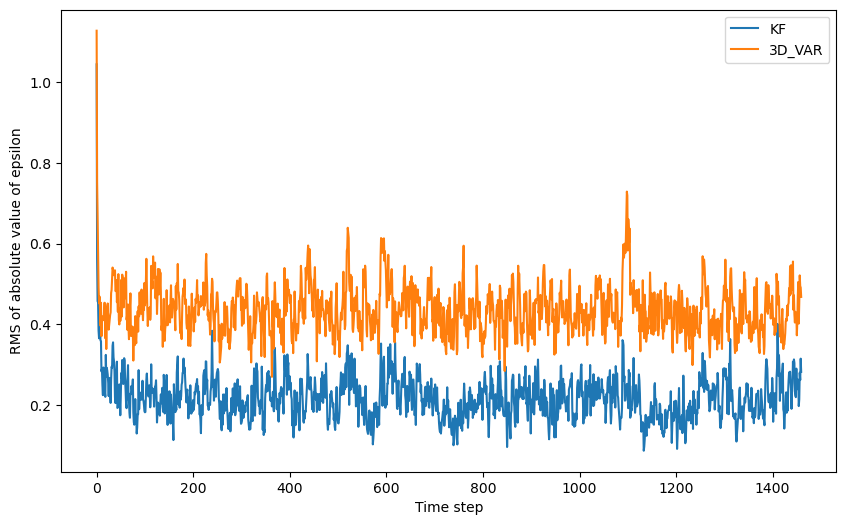

In [97]:
kf = KF(calculation = cal)
kf_a, kf_f = kf.run_simulation()
ls = range(len(kf_a))
three_d_var = Three_D_VAR(calculation = cal)
tdv_a, tdv_f = three_d_var.run_simulation()
plt.figure(figsize=(10, 6))
plt.xlabel('Time step')
plt.ylabel('RMS of absolute value of epsilon')
plt.plot(ls, kf_a, label = "KF")
plt.plot(ls, tdv_a, label = "3D_VAR")
plt.legend()
plt.show()

In [140]:
obs = list(range(2,41))
error_obs_3DVAR = []
obs.reverse()
for i in obs:
    three_d_var = Three_D_VAR(calculation = cal, obs_point = i, method = 1)
    error_a, error_f = three_d_var.run_simulation()
    error_obs_3DVAR.append(np.mean(error_a))

In [141]:
#obs_point <= 35は桁あふれ
overflow = 35
error_obs_KF = [5] * overflow
for i in range(overflow + 1,40):
    kf = KF(calculation = cal, obs_point = i, method = 1)
    error_a, error_f = kf.run_simulation()
    error_obs_KF.append(np.mean(error_a))
error_obs_KF.reverse()

KeyboardInterrupt: 

In [ ]:
plt.xlabel('Observation points')
plt.ylabel('Mean of RMS of epsilon')
plt.plot(obs,error_obs_KF, label = "KF")
plt.plot(obs,error_obs_3DVAR, label = "3D_VAR")
plt.legend()
plt.show()

In [201]:
obs = list(range(2,41))
error_obs_3DVAR = []
obs.reverse()
for i in obs:
    three_d_var = Three_D_VAR(calculation = cal, obs_point = i, method = 1)
    error_a, error_f = three_d_var.run_simulation()
    error_obs_3DVAR.append(np.mean(error_a))

In [202]:
obs_2 = list(range(2,41))
error_obs_3DVAR_2 = []
obs_2.reverse()
for i in obs_2:
    three_d_var = Three_D_VAR(calculation = cal, obs_point = i, method = 2)
    error_a, error_f = three_d_var.run_simulation()
    error_obs_3DVAR_2.append(np.mean(error_a))

In [217]:
obs_3 = list(range(2,41))
error_obs_3DVAR_3 = []
obs_3.reverse()
for i in obs_2:
    three_d_var = Three_D_VAR(calculation = cal, obs_point = i, method = 3)
    error_a, error_f = three_d_var.run_simulation()
    error_obs_3DVAR_3.append(np.mean(error_a))

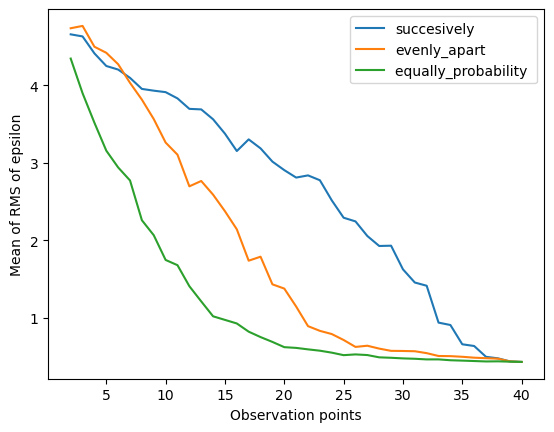

In [218]:
plt.xlabel('Observation points')
plt.ylabel('Mean of RMS of epsilon')
plt.plot(obs, error_obs_3DVAR, label = "succesively")
plt.plot(obs_2,error_obs_3DVAR_2, label = "evenly_apart")
plt.plot(obs_3,error_obs_3DVAR_3, label = "equally_probability ")
plt.legend()
plt.show()